In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import pyfesom2  as pf
import xarray    as xr

/home/ollie/pscholz/tripyview_github


In [2]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 5
which_mode= 'transect_tseries'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'vflx'
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None

input_transect = list()
input_transect.append([[-66, -66,  -67, -55], 'Drake Passage @ 66°W, 67°S-55°S'])

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
which_dpi = 300
do_allcycl= False
do_concat = False

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
# mymesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
#                       do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if ref_path is not None:
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
    
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac   
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record  

0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE


In [4]:
# load mesh with pyfesom2
mesh = pf.load_mesh(mesh_path)

# load mesh diagnostic with pyfesom2
fname = 'fesom.mesh.diag.nc'
if   os.path.isfile( os.path.join(input_paths[0], fname) ): 
    dname = input_paths[0]
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(input_paths[0])),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(input_paths[0])),'1/')
elif os.path.isfile( os.path.join(mesh_path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')
diagpath = os.path.join(dname,fname)
mesh_diag = xr.open_dataset(diagpath)

/work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node/pickle_mesh_py3_fesom2


In [5]:
#_______________________________________________________________________________________________
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

#_______________________________________________________________________________________________
# compute volume transport through section 
vflxtseries_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    transport, section = pf.cross_section_transport(
        input_transect[0][0],              # select a section from the presets or [lon1, lon2, lat1, lat2]
        mesh=mesh,                         # mesh
        data_path=datapath,                # directory of the u, v, (T, S, uice, vice, m_ice, a_ice) files
        mesh_diag=mesh_diag,               # mesh_diag
        years=np.arange(year[0],year[1]+1),  # years to compute
        use_great_circle=False,            # compute the section as a great circle
        how='ori',                         # 'ori' do not apply mean, 'mean' apply time mean
        add_TS=False,                      # add temperature and salinity to the section
        add_extent=10,                      # the extent to look for gridcells nerby the section, choose large for low resolutions
        n_points=1000                      # number of waypoints between the start and end of the section
        )

    #____________________________________________________________________________________________
    # comppute net-transpoort through section
    vflx = transport.transport_across.sum(dim=('elem','nz1')) * 1e-6
    vflxtseries_list.append(vflx)

time = transport['time.year'].data + (transport['time.month'].data-12)/12 

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/5/ TKE
Starting computation...

Your section:  not specified : Start:  -66 °E  -67 °N  End:  -66 °E  -55 °N

Converting grid cells to Polygons... (If this takes very long try to reduce the add_extent parameter)


  0%|          | 0/2967 [00:00<?, ?it/s]

Looking for intersected grid cells...


  0%|          | 0/2967 [00:00<?, ?it/s]

Loading the data into memory...
[########################################] | 100% Completed | 12.2s

 Done!


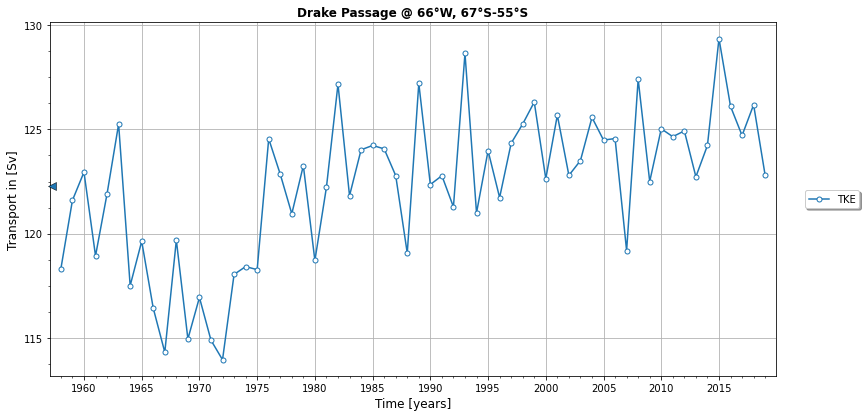

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = input_transect[0][1].replace(' ','_')
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
    
fig,ax=tpv.plot_vflx_tseries(time, vflxtseries_list, input_names, input_transect[0][1],  
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_concat=do_concat, 
                              do_save=spath, save_dpi=which_dpi, )  